# Introduction

## Sunspots


Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas.

They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection.

Sunspots usually appear in pairs of opposite magnetic polarity. The number of sunspots goes up and down as the Sun goes through its natural 11-year cycle. Scientists use sunspots to help them track this cycle.

The following graph shows the monthly mean sunspot number (blue) and 13-month smoothed monthly sunspot number (red) for the last five cycles.

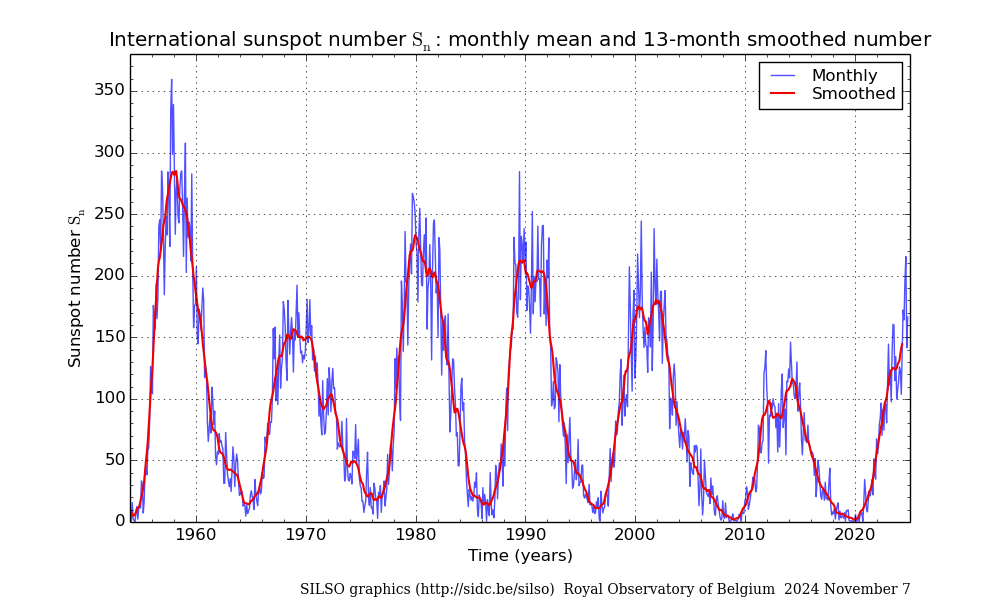

## Sunspots dataset


The sunspots dataset contains the monthly mean total sunspot number every years from 1749 to 2023.

The dataset could be downloaded from the following link:

[https://drive.google.com/file/d/1d8MiMRgDMb3Zp_F17RZ98HfaVUo0Qs7R/view?usp=sharing](https://drive.google.com/file/d/1d8MiMRgDMb3Zp_F17RZ98HfaVUo0Qs7R/view?usp=sharing)

## Sunspots number prediction

In this tutorial, we will create an RNN model for a regression task to predict the monthly total sunspot number based on the observed sunspots dataset.

We will proceed as follows:

1. Investigate and preprocess the dataset.

2. Create suitable input data for the RNN model.

3. Specify, compile, and fit the RNN model.

4. Make predictions on the training and test sets.

# Data preprocessing

## Load dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('sunspots.csv', sep=';')
data.head(20)

,Year,Month,Monthly Mean Total Sunspot Number
0,1749,1,96.7
1,1749,2,104.3
2,1749,3,116.7
3,1749,4,92.8
4,1749,5,141.7
5,1749,6,139.2
6,1749,7,158.0
7,1749,8,110.5
8,1749,9,126.5
9,1749,10,125.8


In [3]:
data.shape

(3300, 3)

## Visualize the time series data

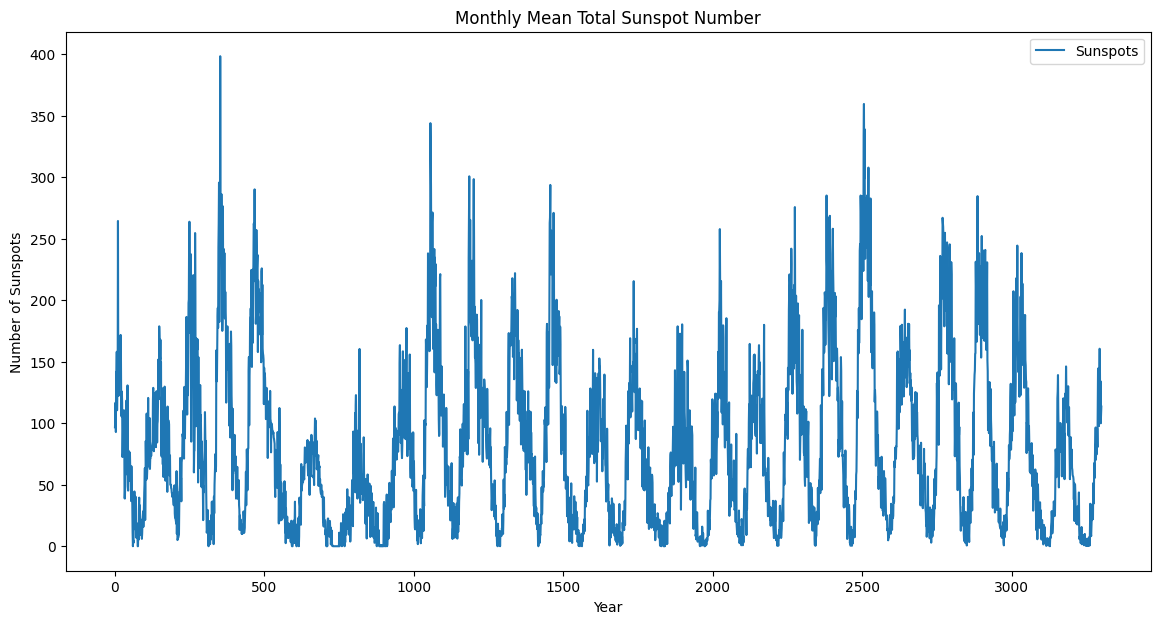

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(data['Monthly Mean Total Sunspot Number'], label='Sunspots')
plt.title('Monthly Mean Total Sunspot Number')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(False)
plt.show()

## Scaling the data between 0 and 1

We will use `MinMaxScaler` from scikit-learn to scale our data values between 0 and 1.

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
series = data['Monthly Mean Total Sunspot Number'].to_numpy()
print(series)
series = scaler.fit_transform(series.reshape(-1, 1)).flatten()
print(series)

[ 96.7 104.3 116.7 ...  99.9 107.1 113.5]
[0.24284279 0.26192868 0.29306881 ... 0.25087896 0.26896032 0.28503265]


# Create input data

We will use the `sliding window ` approach to create input data sample to train our RNN model.

We will set the `window_size` to `12` for the sunspots dataset as the sunspots generally have a cycle of 12 months.

We take a window of a fixed size - 12 elements, and put that in the first row of our training data. From these 12 elements, we want to output the 13rd element, which is the label of the first sample. So we will set the `steps_ahead` to `1` to predict only one output element.

We keep sliding the window across, one element each time, to create a set of input samples and the corresponding labels that we can input into our RNN model.

In [6]:
def create_dataset(series, window_size, steps_ahead):
    x = np.zeros((series.shape[0] - (window_size + steps_ahead - 1), window_size))
    y = np.zeros((series.shape[0] - (window_size + steps_ahead - 1), steps_ahead))

    for i in range(series.shape[0]):
        window = series[i : i + window_size + steps_ahead]
        if window.shape[0] < window_size + steps_ahead:
            break
        x[i], y[i] = window[:-steps_ahead], window[-steps_ahead:]

    return x, y

In [7]:
window_size = 12
steps_ahead = 1
X, Y = create_dataset(series, window_size=window_size, steps_ahead=steps_ahead)

In [8]:
print(X.shape, Y.shape)

for x, y in zip(X[:10], Y[:10]):
    print(f"{x} ----> {y}")

(3288, 12) (3288, 1)
[0.24284279 0.26192868 0.29306881 0.23304872 0.35585133 0.34957308
 0.39678553 0.27749874 0.31767956 0.31592165 0.66373682 0.35660472] ----> [0.30688096]
[0.26192868 0.29306881 0.23304872 0.35585133 0.34957308 0.39678553
 0.27749874 0.31767956 0.31592165 0.66373682 0.35660472 0.30688096] ----> [0.31767956]
[0.29306881 0.23304872 0.35585133 0.34957308 0.39678553 0.27749874
 0.31767956 0.31592165 0.66373682 0.35660472 0.30688096 0.31767956] ----> [0.37343044]
[0.23304872 0.35585133 0.34957308 0.39678553 0.27749874 0.31767956
 0.31592165 0.66373682 0.35660472 0.30688096 0.31767956 0.37343044] ----> [0.36966349]
[0.35585133 0.34957308 0.39678553 0.27749874 0.31767956 0.31592165
 0.66373682 0.35660472 0.30688096 0.31767956 0.37343044 0.36966349] ----> [0.37669513]
[0.34957308 0.39678553 0.27749874 0.31767956 0.31592165 0.66373682
 0.35660472 0.30688096 0.31767956 0.37343044 0.36966349 0.37669513] ----> [0.41863385]
[0.39678553 0.27749874 0.31767956 0.31592165 0.66373682

## Create training and testing set

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2959, 12) (2959, 1)
(329, 12) (329, 1)


# Specify, compile and fit RNN model

## Create a simple RNN model

Our RNN model includes three simple RNN layers. Each RNN layer has 50 hidden units.

We want to to predict only one number as the output. Therefore, we add a dense layer perceptron at the end.

Because input and output values are in the range from 0 to 1, we will use `tanh` activation function.

We use `mean_squared_error` as the loss function, `adam` as the optimizer algorithm, and `mse` as the metrics when compiling the model.

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

def create_RNN(input_shape):
    model = Sequential()
    #Adding the first RNN layer
    model.add(SimpleRNN(50, input_shape=input_shape, activation='tanh', return_sequences=True))

    #Adding the second RNN layer
    model.add(SimpleRNN(50, activation='tanh', return_sequences=True))

    #Adding the third RNN layer
    model.add(SimpleRNN(50, activation='tanh'))

    model.add(Dense(units=1, activation='tanh'))
    return model


In [21]:
model = create_RNN(input_shape=(window_size,1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

c:\Users\DELL\Documents\NewThingie\ATI\git\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 12, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 12, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.fit(X_train, Y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0176 - mse: 0.0176
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - mse: 0.0045
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mse: 0.0047
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - mse: 0.0046
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mse: 0.0043
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - mse: 0.0045
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - mse: 0.0044
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mse: 0.0043
Epoch 9/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0043 - mse: 0.0043
Epoch 10/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - mse: 0.0044
Epoch 11/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - mse: 0.0042
Epoch 12/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - mse: 0.0044
Epoch 13/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/st

## View the Result

In [23]:
# Plot the result
def plot_result(Y_test, test_predict):
    # convert values back to original data
    actual = scaler.inverse_transform(Y_test)
    predictions = scaler.inverse_transform(test_predict)

    rows = len(actual)
    plt.figure(figsize=(14, 7))
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots numbers')
    plt.title('Actual and Predicted Values')

In [24]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [25]:
print(test_predict[:10])

[[0.04820954]
 [0.12190017]
 [0.05370314]
 [0.29335776]
 [0.05315938]
 [0.12621118]
 [0.10291029]
 [0.53868604]
 [0.04203126]
 [0.04135983]]


In [26]:
# Compute and Print the Root Mean Square Error
from sklearn.metrics import root_mean_squared_error

train_rmse = root_mean_squared_error(Y_train, train_predict)
print(f"Train RMSE: {train_rmse}")

test_rmse = root_mean_squared_error(Y_test, test_predict)
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.06152056888452883
Test RMSE: 0.06983073592268416


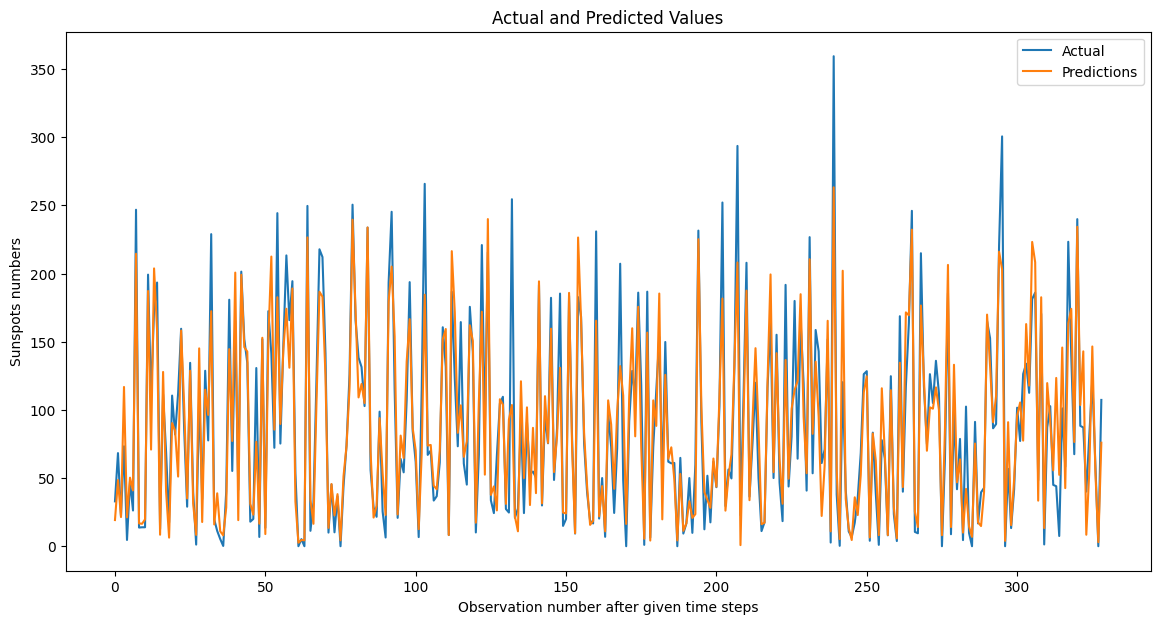

In [27]:
plot_result(Y_test, test_predict)